In [2]:
import webdataset as wds
from itertools import cycle
from IPython.display import display
import numpy as np
import cv2
import io
import torch
from PIL import Image
import open_clip

/fsx/robvanvolt/hand-inference/.env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [69]:
ds = wds.WebDataset("pipe:aws s3 cp s3://s-datasets/laion5b/laion2B-data/000000.tar -")

cycle_ds = cycle(ds)

batch = next(cycle_ds)

# np_array = np.frombuffer(batch['jpg'], np.uint8)
# img2 = cv2.imdecode(np_array, cv2.IMREAD_COLOR)     
# img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

In [3]:
# ('ViT-g-14', 'laion2b_s12b_b42k')
model, _, preprocess = open_clip.create_model_and_transforms('ViT-bigG-14', pretrained='laion2b_s39b_b160k')
tokenizer = open_clip.get_tokenizer('ViT-bigG-14')

# image = preprocess(Image.open(io.BytesIO(batch['jpg'])).convert("RGB")).unsqueeze(0)
# text = tokenizer(["hand", "finger", "hands", "fingers"])

# with torch.no_grad(), torch.cuda.amp.autocast():
#     image_features = model.encode_image(image)
#     text_features = model.encode_text(text)
#     image_features /= image_features.norm(dim=-1, keepdim=True)
#     text_features /= text_features.norm(dim=-1, keepdim=True)

#     text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

# print("Label probs:", text_probs)

/fsx/robvanvolt/hand-inference/.env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/fsx/robvanvolt/hand-inference/.env/lib/python3.8/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Label probs: tensor([[0.3411, 0.1864, 0.4563, 0.0162]])


Label probs: tensor([[ 6.6527,  6.0897, 10.9439, 15.0526]])
tensor(6.6527)
tensor(12.9983)


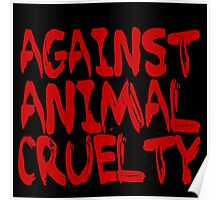

Label probs: tensor([[11.3195, 11.9204, 20.3523, 17.5127]])
tensor(11.9204)
tensor(18.9325)


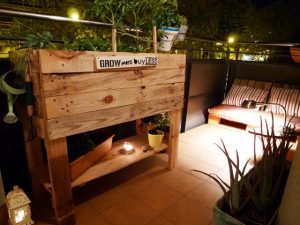

Label probs: tensor([[16.2946, 14.8735, 17.5541, 20.1013]])
tensor(16.2946)
tensor(18.8277)


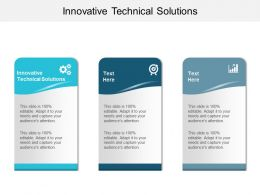

Label probs: tensor([[12.4483, 18.5754, 20.7511, 20.2759]])
tensor(18.5754)
tensor(20.5135)


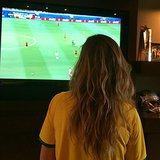

Label probs: tensor([[19.5227, 23.5180, 16.3541, 18.9897]])
tensor(23.5180)
tensor(17.6719)


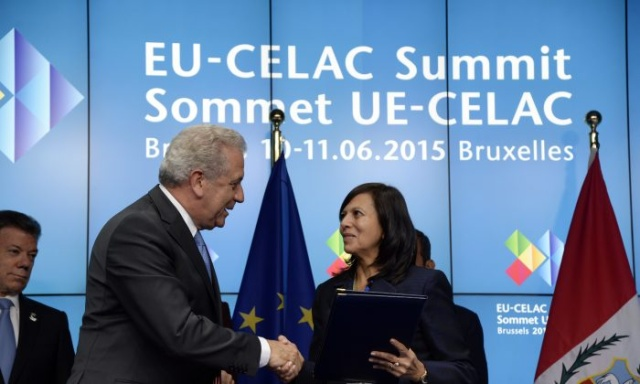

In [121]:
# batch = next(cycle_ds)

def look_for_hands(img):
    raw_image = Image.open(io.BytesIO(img)).convert("RGB")
    image = preprocess(raw_image).unsqueeze(0)
    # text = tokenizer(["hand", "hands", "finger", "fingers", "human", "man", "woman", "a thing", "building", "lanscape", "anorganic"])
    text = tokenizer(["a man showing his hands", "a woman showing her hands", "invisible hands", "image without hands"])

    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        text_probs = (100.0 * image_features @ text_features.T) # .softmax(dim=-1)

    print("Label probs:", text_probs)
    # # print("Average: ", text_probs.sum(1))
    print(text_probs[0][:2].max())
    print(text_probs[0][2:].mean())
    display(raw_image)

    # if text_probs[0][:2].max() > text_probs[0][2:].mean():
    #     display(raw_image)

b = next(cycle_ds)
look_for_hands(b['jpg'])
b = next(cycle_ds)
look_for_hands(b['jpg'])
b = next(cycle_ds)
look_for_hands(b['jpg'])
b = next(cycle_ds)
look_for_hands(b['jpg'])
b = next(cycle_ds)
look_for_hands(b['jpg'])

# i = 0
# while i < 500:
#     b = next(cycle_ds)
#     look_for_hands(b['jpg'])
#     i += 1


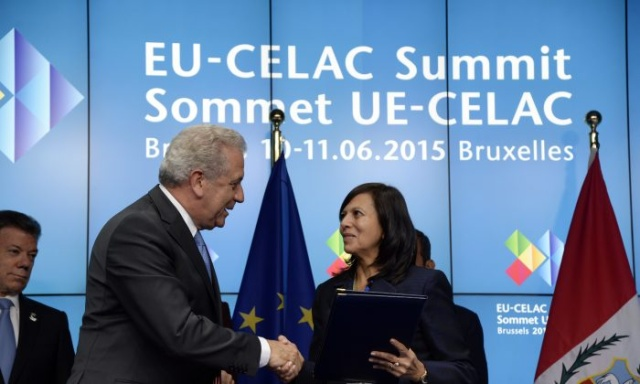

In [124]:
raw_image = Image.open(io.BytesIO(b['jpg'])).convert("RGB")
display(raw_image)

In [1]:
import argparse
import glob
import os

import cv2

from yolo import YOLO

ap = argparse.ArgumentParser()
imagepath = "images"
device = "0"

print("loading yolo-tiny-prn...")
yolo = YOLO("models/cross-hands-yolov4-tiny.cfg", "models/cross-hands-yolov4-tiny.weights", ["hand"])
# yolo = YOLO("models/cross-hands-tiny-prn.cfg", "models/cross-hands-tiny-prn.weights", ["hand"])
yolo.size = int(416)
yolo.confidence = float(0.25)

print("extracting tags for each image...")

if imagepath.endswith(".txt"):
    with open(imagepath, "r") as myfile:
        lines = myfile.readlines()
        files = map(lambda x: os.path.join(os.path.dirname(imagepath), x.strip()), lines)
else:
    files = sorted(glob.glob("%s/*.jpg" % imagepath))

conf_sum = 0
detection_count = 0

for i, file in enumerate(files):
    print(file)
    # mat = cv2.imread(file)
    im = Image.open(file)

    #### Uncomment if you want resize
    # w, h = im.size
    # if w > h:
    #     new_w = 416
    #     new_h = int(416*h/w)
    # else:
    #     new_h = 416
    #     new_w = int(416*w/h)
    # mat = np.asarray(im.resize((new_w, new_h)))[:, :, ::-1].copy()
    ####

    mat = np.asarray(im)[:, :, ::-1].copy()

    width, height, inference_time, results = yolo.inference(mat)

    print(str(width) + ", " + str(height))

    print("%s in %s seconds: %s classes found!" %
          (os.path.basename(file), round(inference_time, 2), len(results)))

    output = []

    # cv2.namedWindow('image', cv2.WINDOW_NORMAL)
    # cv2.resizeWindow('image', 848, 640)

    for j, detection in enumerate(results):
        id, name, confidence, x, y, w, h = detection

        cx = x + (w / 2)
        cy = y + (h / 2)

        os.makedirs(f"./images_output/export_{i:02d}/", exist_ok=True)
        # im_crop = im.crop((x, y, x + w, y + h))
        # im_crop.save(f"./images_output/export_{i:02d}/{j:02d}.jpg")
        
        im_crop = mat[y:y+h, x:x+w]
        cv2.imwrite(f"./images_output/export_{i:02d}/{j:02d}.jpg", im_crop)


        output.append([int(1000*x/width)/1000, int(1000*y/height)/1000, int(1000*((x+w)/width))/1000, int(1000*((y+h)/height))/1000, int(1000*confidence)/1000])

        conf_sum += confidence
        detection_count += 1

        # draw a bounding box rectangle and label on the image
        color = (255, 0, 255)
        cv2.rectangle(mat, (x, y), (x + w, y + h), color, 1)
        text = "%s (%s)" % (name, round(confidence, 2))
        cv2.putText(mat, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                    0.25, color, 1)

        print("%s with %s confidence" % (name, round(confidence, 2)))

        cv2.imwrite(f"./images_output/export_{i:02d}.jpg", mat)

    print(output)
    # show the output image
    # cv2.imshow('image', mat)
    # cv2.waitKey(0)

# print("AVG Confidence: %s Count: %s" % (round(conf_sum / detection_count, 2), detection_count))
# cv2.destroyAllWindows()

loading yolo-tiny-prn...
extracting tags for each image...
images/alexis-brown-omeaHbEFlN4-unsplash.jpg


NameError: name 'Image' is not defined

[[[ 42 158]
  [114 237]
  [ 62 182]
  [ 73 178]
  [ 85 181]
  [ 92 189]
  [ 94 197]
  [ 81 193]
  [ 90 208]
  [ 93 207]
  [ 92 204]
  [ 73 199]
  [ 80 216]
  [ 86 216]
  [ 88 211]
  [ 68 202]
  [ 72 217]
  [ 79 216]
  [ 81 211]
  [ 63 203]
  [ 66 214]
  [ 71 214]
  [ 74 210]]

 [[233 147]
  [301 238]
  [259 167]
  [269 172]
  [275 183]
  [277 196]
  [278 204]
  [255 186]
  [268 196]
  [277 195]
  [281 193]
  [253 190]
  [262 204]
  [268 212]
  [272 218]
  [255 193]
  [269 203]
  [276 203]
  [280 202]
  [258 195]
  [270 202]
  [276 199]
  [279 195]]]


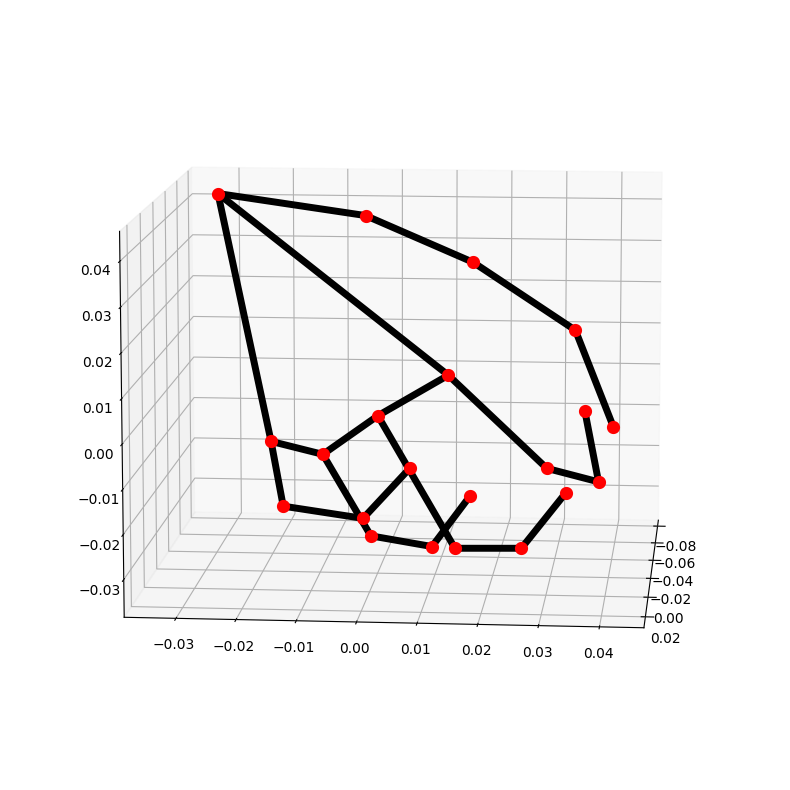

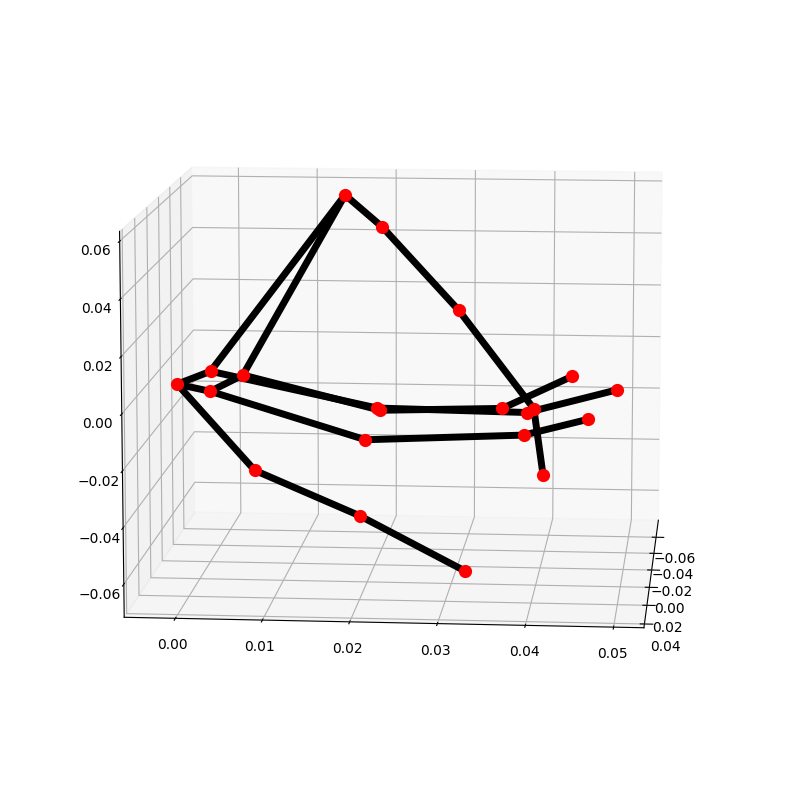

[[[283 535]
  [378 611]
  [358 573]
  [346 565]
  [329 560]
  [314 560]
  [303 556]
  [335 555]
  [314 564]
  [313 571]
  [317 573]
  [342 563]
  [318 575]
  [319 579]
  [324 578]
  [347 573]
  [324 584]
  [326 586]
  [332 584]
  [350 583]
  [331 591]
  [333 591]
  [339 588]]

 [[159 547]
  [238 626]
  [182 571]
  [193 567]
  [204 568]
  [211 575]
  [216 582]
  [188 572]
  [203 584]
  [212 589]
  [218 592]
  [181 583]
  [202 595]
  [209 593]
  [210 590]
  [179 592]
  [200 601]
  [205 597]
  [205 593]
  [180 600]
  [197 606]
  [201 603]
  [201 600]]]


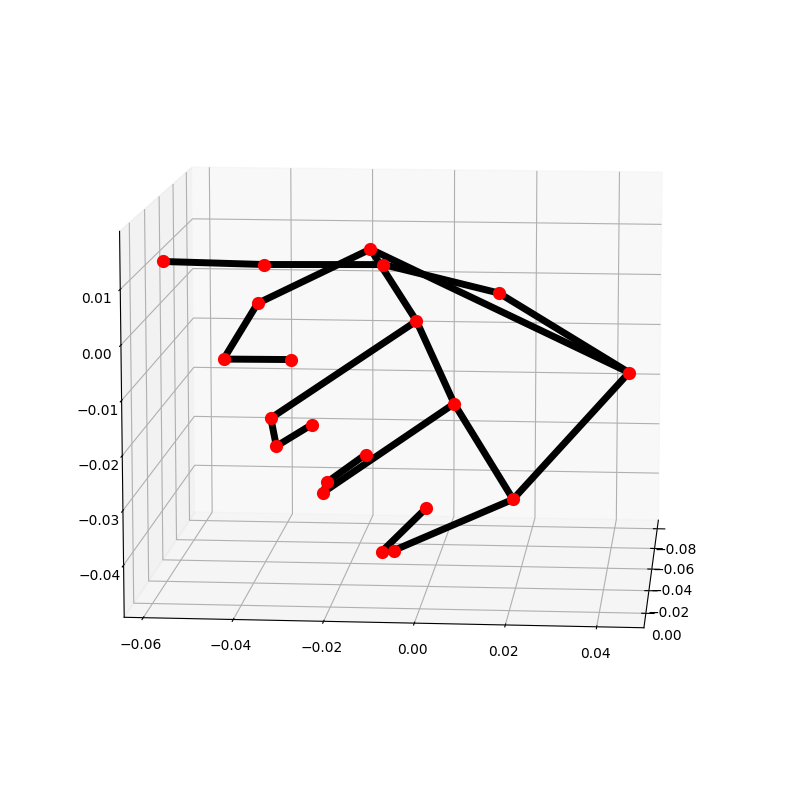

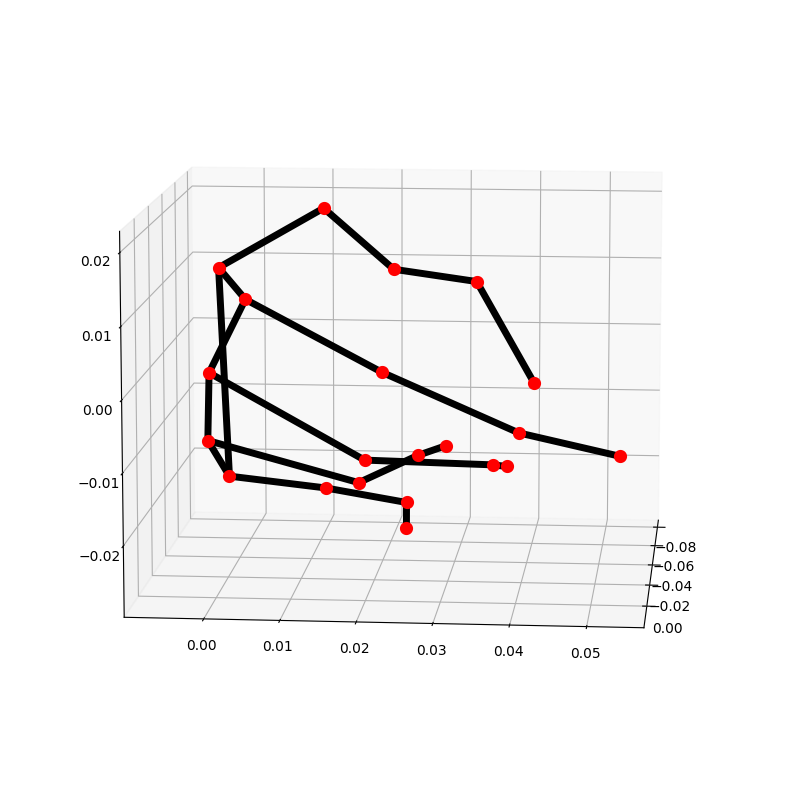

[[[346 184]
  [443 329]
  [423 309]
  [414 286]
  [405 263]
  [395 247]
  [385 236]
  [415 248]
  [400 219]
  [381 208]
  [366 204]
  [418 256]
  [400 225]
  [379 226]
  [367 235]
  [415 267]
  [393 242]
  [373 250]
  [366 259]
  [409 281]
  [384 269]
  [371 278]
  [368 287]]]


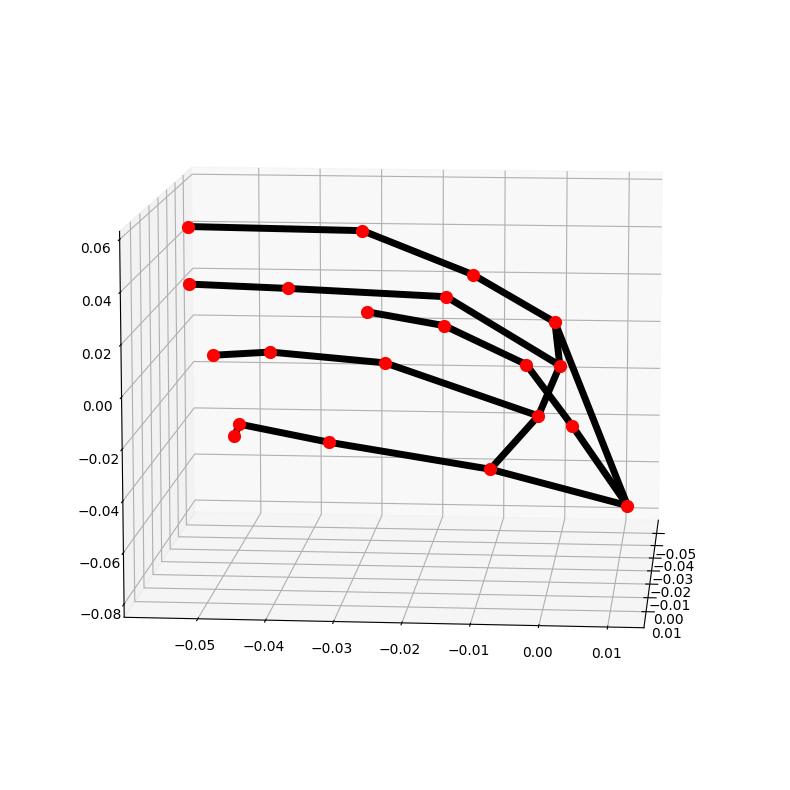

[[[ 40  68]
  [246 334]
  [140 314]
  [177 291]
  [198 247]
  [212 211]
  [226 185]
  [167 198]
  [168 154]
  [167 125]
  [165 101]
  [139 197]
  [136 148]
  [134 115]
  [131  88]
  [115 206]
  [106 161]
  [102 132]
  [ 98 106]
  [ 92 224]
  [ 77 190]
  [ 67 168]
  [ 60 145]]

 [[328 117]
  [546 377]
  [460 357]
  [417 344]
  [387 312]
  [367 282]
  [348 257]
  [417 253]
  [412 207]
  [410 177]
  [409 153]
  [446 250]
  [445 199]
  [446 164]
  [447 137]
  [472 256]
  [475 208]
  [477 179]
  [476 152]
  [497 268]
  [511 233]
  [519 212]
  [526 191]]]


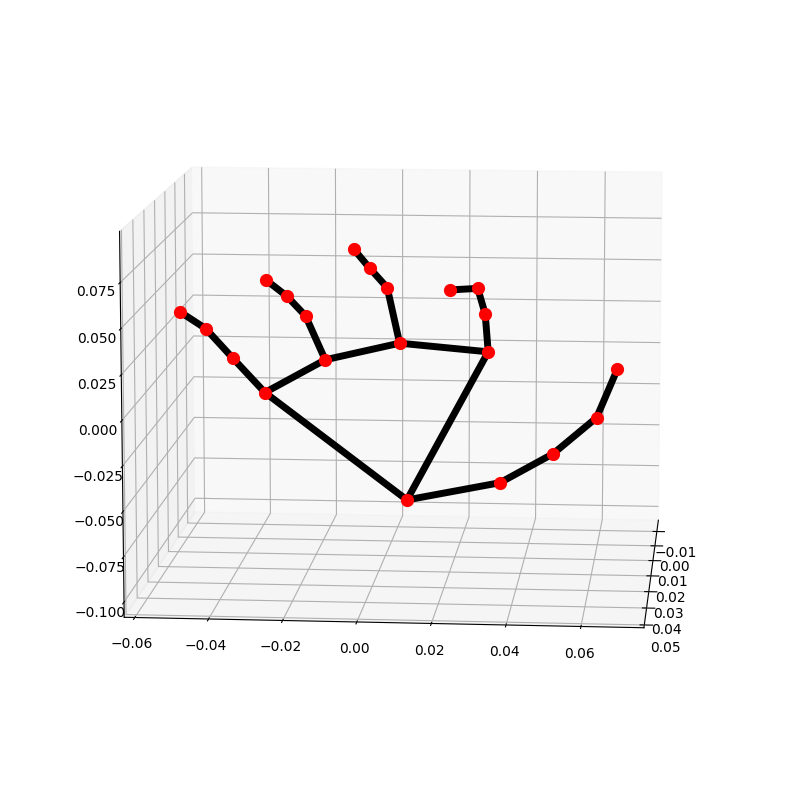

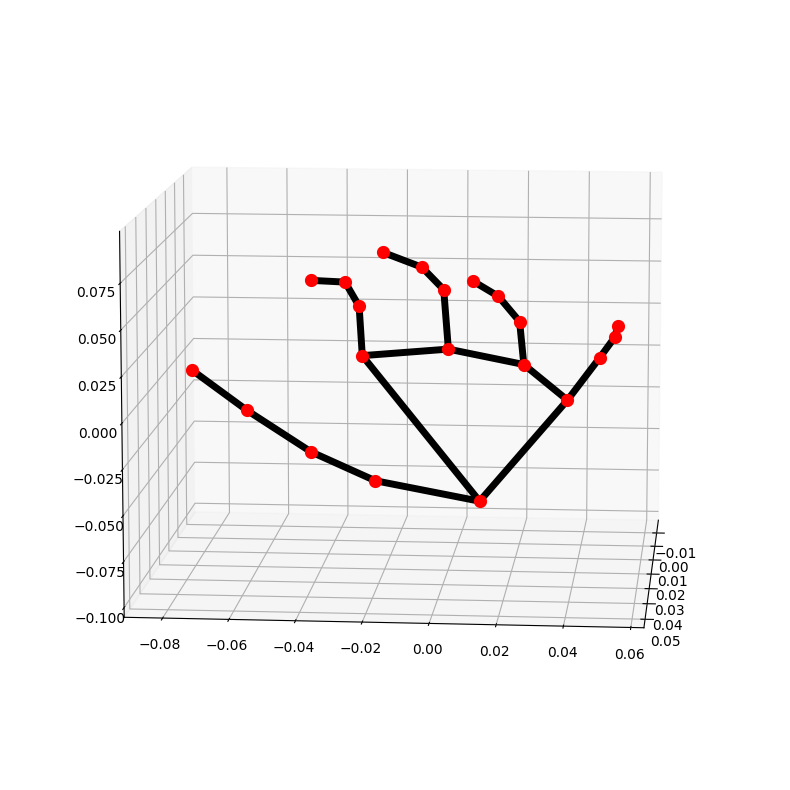

[[[375 213]
  [523 321]
  [503 286]
  [490 299]
  [466 301]
  [448 294]
  [434 286]
  [442 285]
  [422 279]
  [408 277]
  [397 274]
  [443 273]
  [420 265]
  [406 259]
  [395 255]
  [448 262]
  [427 254]
  [414 247]
  [403 240]
  [458 253]
  [440 245]
  [429 239]
  [420 233]]

 [[340 301]
  [493 387]
  [473 347]
  [462 329]
  [440 321]
  [420 324]
  [405 324]
  [414 332]
  [393 331]
  [379 330]
  [369 331]
  [412 344]
  [386 342]
  [372 342]
  [360 342]
  [414 355]
  [389 353]
  [373 352]
  [360 350]
  [420 367]
  [400 366]
  [387 365]
  [374 363]]]


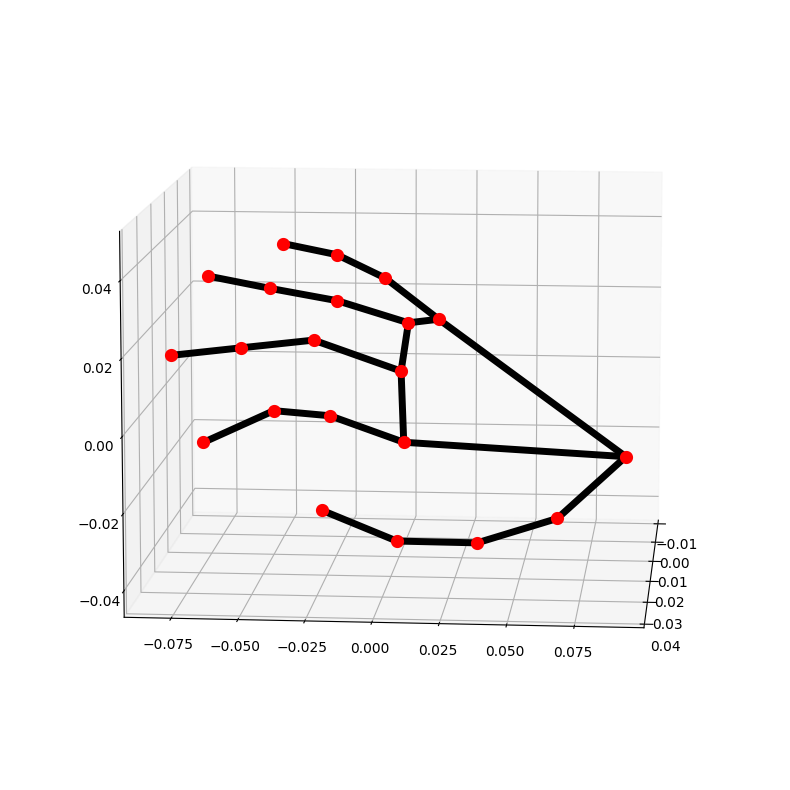

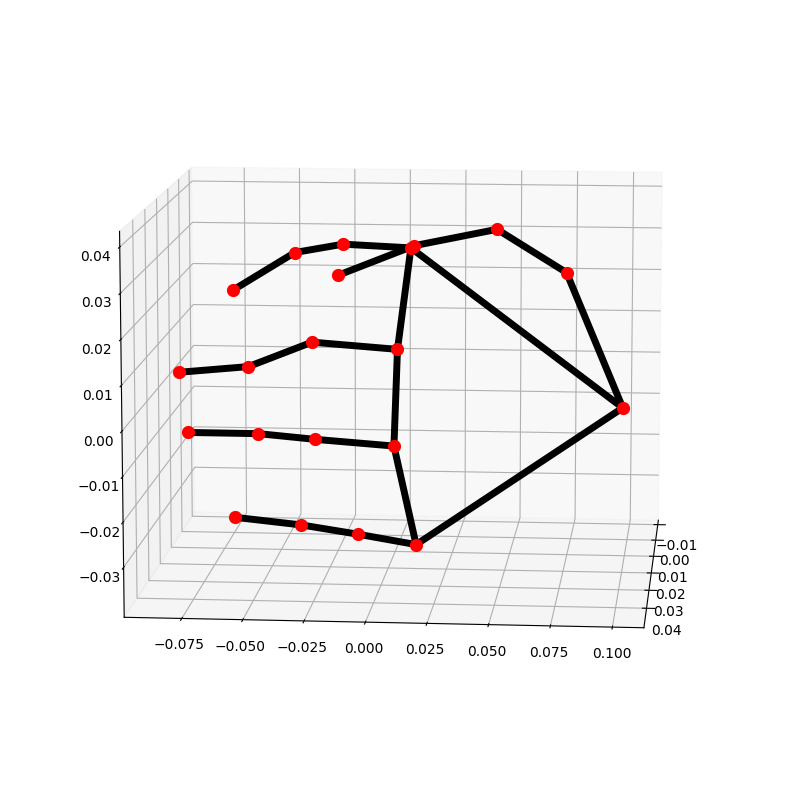

[[[169  26]
  [238 109]
  [194  89]
  [202  86]
  [209  81]
  [214  77]
  [218  74]
  [204  67]
  [208  60]
  [211  56]
  [213  52]
  [199  64]
  [202  55]
  [204  50]
  [206  46]
  [195  64]
  [196  55]
  [198  50]
  [199  46]
  [190  66]
  [189  58]
  [189  54]
  [189  49]]]


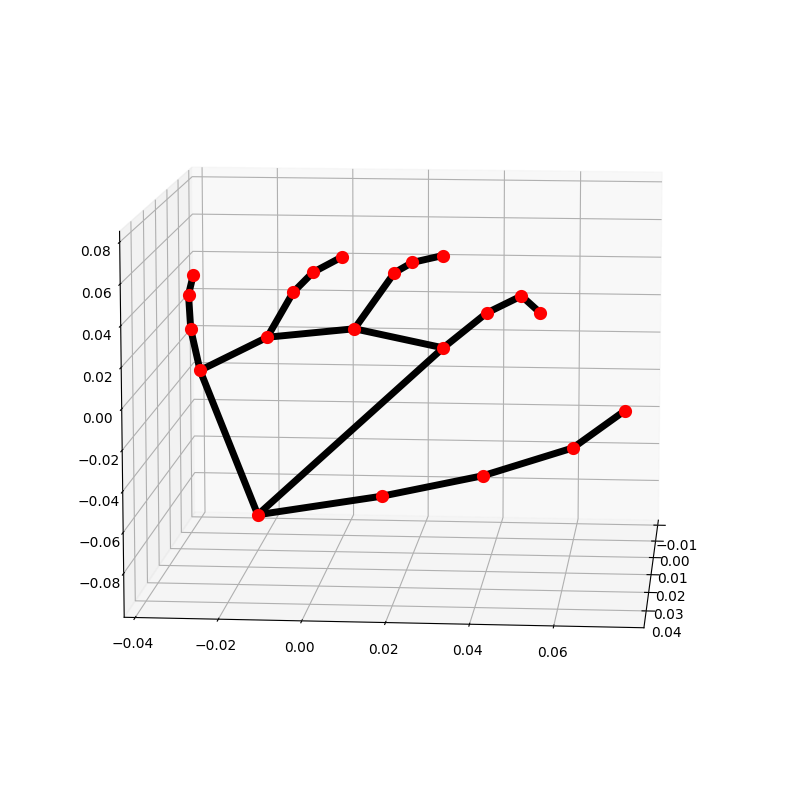

In [22]:
#### not clean

import os
import cv2
import glob
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

# For static images:
# IMAGE_FILES = []
imagepath = "images"
IMAGE_FILES = sorted(glob.glob("%s/*.jpg" % imagepath))

with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=4,
    min_detection_confidence=0.5) as hands:
  for idx, file in enumerate(IMAGE_FILES):
    # Read an image, flip it around y-axis for correct handedness output (see
    # above).
    image = cv2.flip(cv2.imread(file), 1)
    # Convert the BGR image to RGB before processing.
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Print handedness and draw hand landmarks on the image.
    # print('Handedness:', results.multi_handedness)
    if not results.multi_hand_landmarks:
      continue
    image_height, image_width, _ = image.shape
    annotated_image = image.copy()

    hand_landmarks_output = []

    for jdx, hand_landmarks in enumerate(results.multi_hand_landmarks):
      # print('hand_landmarks:', hand_landmarks)
      # print(f'Hand {jdx}')
      # print(hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP])
      # print(
      #     f'Index finger tip coordinates: (',
      #     f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x * image_width}, '
      #     f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y * image_height})'
      # )

      ######### BOUNDING BOXES HANDS
      xList = []
      yList = []
      bbox = []
      bboxInfo =[]
      lmList = []
    
      for id, lm in enumerate(hand_landmarks.landmark):
          h, w, c = image.shape
          px, py = int(lm.x * w), int(lm.y * h)
          xList.append(px)
          yList.append(py)
          lmList.append([px, py])
          # cv2.circle(image, (px, py), 2, (255, 0, 255), cv2.FILLED)
      
      xmin, xmax = min(xList), max(xList)
      ymin, ymax = min(yList), max(yList)
      boxW, boxH = xmax - xmin, ymax - ymin
      bbox = xmin, ymin, boxW, boxH
      cx, cy = bbox[0] + (bbox[2] // 2), \
                bbox[1] + (bbox[3] // 2)
      bboxInfo = {"id": id, "bbox": bbox,"center": (cx, cy)}

      # print((bbox[0] - 20, bbox[1] - 20),(bbox[0] + bbox[2] + 20, bbox[1] + bbox[3] + 20))
      # xmin, ymin, xmax, ymax
      hand_xminyminxmaxymax = [[bbox[0]-20, bbox[1]-20], [bbox[0]+bbox[2]+20, bbox[1]+bbox[3]+20]]
      hand_landmarks_output.append(np.vstack((np.array(hand_xminyminxmaxymax), np.array(lmList))))
      # print(hand_xminyminxmaxymax)

      # hand_landmarks_output.append(np.array([hand_xminyminxmaxymax, np.array(lmList)]))

      # im_crop = image[y:y+h, x:x+w]
      im_crop = image[bbox[1]-20:bbox[1]+bbox[3]+20, bbox[0]-20:bbox[0]+bbox[2]+20]

      os.makedirs(f"./images_output/annotated_image_{idx}/", exist_ok=True)
      cv2.imwrite(f"./images_output/annotated_image_{idx}/{jdx}.jpg", im_crop)
      ######### END BOUNDING BOXES HANDS

      mp_drawing.draw_landmarks(
          annotated_image,
          hand_landmarks,
          mp_hands.HAND_CONNECTIONS,
          mp_drawing_styles.get_default_hand_landmarks_style(),
          mp_drawing_styles.get_default_hand_connections_style())

    print(np.array(hand_landmarks_output))
    
    cv2.imwrite(
        './images_output/annotated_image' + str(idx) + '.png', cv2.flip(annotated_image, 1))
    # Draw hand world landmarks.
    if not results.multi_hand_world_landmarks:
      continue
    for hand_world_landmarks in results.multi_hand_world_landmarks:
      mp_drawing.plot_landmarks(
        hand_world_landmarks, mp_hands.HAND_CONNECTIONS, azimuth=5)


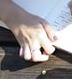

NameError: name 'idx' is not defined

In [18]:
#### clean

import os
import cv2
import glob
import mediapipe as mp
from PIL import Image

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

imagepath = "images"
IMAGE_FILES = sorted(glob.glob("%s/*.jpg" % imagepath))
IMAGE_PATH = IMAGE_FILES[0]

def get_hand_coordinates_and_landmarks(IMAGE_PATH):
    with mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=4,
        min_detection_confidence=0.5) as hands:

        # Read an image, flip it around y-axis for correct handedness output (see
        # above).
        image = cv2.flip(cv2.imread(IMAGE_PATH), 1)
        # Convert the BGR image to RGB before processing.
        results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        if results.multi_hand_landmarks:
            image_height, image_width, _ = image.shape
            annotated_image = image.copy()

            hand_landmarks_output = []

            for jdx, hand_landmarks in enumerate(results.multi_hand_landmarks):
                xList = []
                yList = []
                bbox = []
                bboxInfo =[]
                lmList = []

                for id, lm in enumerate(hand_landmarks.landmark):
                    h, w, c = image.shape
                    px, py = int(lm.x * w), int(lm.y * h)
                    xList.append(px)
                    yList.append(py)
                    lmList.append([px, py])
                
                xmin, xmax = min(xList), max(xList)
                ymin, ymax = min(yList), max(yList)
                boxW, boxH = xmax - xmin, ymax - ymin
                bbox = xmin, ymin, boxW, boxH

                hand_xminyminxmaxymax = [[bbox[0]-20, bbox[1]-20], [bbox[0]+bbox[2]+20, bbox[1]+bbox[3]+20]]
                hand_landmarks_output.append(np.vstack((np.array(hand_xminyminxmaxymax), np.array(lmList))))
                
                im_crop = image[bbox[1]-20:bbox[1]+bbox[3]+20, bbox[0]-20:bbox[0]+bbox[2]+20]

                display(Image.fromarray(im_crop))

                os.makedirs(f"./images_output/annotated_image_{idx}/", exist_ok=True)
                cv2.imwrite(f"./images_output/annotated_image_{idx}/{jdx}.jpg", im_crop)

            print(np.array(hand_landmarks_output))

            cv2.imwrite(
                './images_output/annotated_image' + str(idx) + '.png', cv2.flip(annotated_image, 1))

get_hand_coordinates_and_landmarks(IMAGE_PATH)

In [75]:
#### clean with webdataset

import cv2
import mediapipe as mp
from PIL import Image

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

def get_hand_coordinates_and_landmarks_and_crops(key, byteimage, showImages=False):
    with mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=2,
        min_detection_confidence=0.5) as hands:

        # Read an image, flip it around y-axis for correct handedness output (see
        # above).
        np_array = np.frombuffer(byteimage, np.uint8)

        ### with flip
        # img2 = cv2.imdecode(np_array, cv2.IMREAD_COLOR)     
        # image = cv2.flip(img2, 1)

        ### without flip
        image = cv2.imdecode(np_array, cv2.IMREAD_COLOR)     

        # Convert the BGR image to RGB before processing.
        results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        if results.multi_hand_landmarks:
            if showImages:
                display(Image.fromarray(image[:, :, ::-1]))
                
            hand_landmarks_output = [np.full((24, 2), -1, dtype=int), np.full((24, 2), -1, dtype=int)]
            im_crops = [None, None]

            for i, hand_landmarks in enumerate(results.multi_hand_landmarks):
                xList = []
                yList = []
                bbox = []
                lmList = []

                for lm in hand_landmarks.landmark:
                    h, w, _ = image.shape
                    px, py = int(lm.x * w), int(lm.y * h)
                    xList.append(px)
                    yList.append(py)
                    lmList.append([px, py])
                
                xmin, xmax = min(xList), max(xList)
                ymin, ymax = min(yList), max(yList)
                boxW, boxH = xmax - xmin, ymax - ymin
                bbox = xmin, ymin, boxW, boxH

                hand_xminyminxmaxymax = [[bbox[0]-20, bbox[1]-20], [bbox[0]+bbox[2]+20, bbox[1]+bbox[3]+20]]
                # hand_landmarks_output.append(np.vstack((np.array(hand_xminyminxmaxymax), np.array(lmList))))
                hand_landmarks_output[i] = np.vstack((np.array((int(key), i)), np.array(hand_xminyminxmaxymax), np.array(lmList)))
                
                im_crop = image[bbox[1]-20:bbox[1]+bbox[3]+20, bbox[0]-20:bbox[0]+bbox[2]+20]
                im_crop = im_crop[:, :, ::-1]
                im_crops[i] = im_crop

                if showImages:
                    display(Image.fromarray(im_crop))

                # os.makedirs(f"./images_output/annotated_image_{idx}/", exist_ok=True)
                # cv2.imwrite(f"./images_output/annotated_image_{idx}/{jdx}.jpg", im_crop)

            return hand_landmarks_output, im_crops
        
        return None, None

            # cv2.imwrite(
            #     './images_output/annotated_image' + str(idx) + '.png', cv2.flip(annotated_image, 1))

In [76]:
# b = next(cycle_ds)
import pyarrow as pa
import pyarrow.parquet as pq

keys = []
l = []

### While loop
# i = 0
# while i < 5:
#     b = next(cycle_ds)
#     landmarks, imagearrays = get_hand_coordinates_and_landmarks_and_crops(b['__key__'], b['jpg'])

#     if landmarks is not None:
#         l.append(landmarks)
#         keys.append(b['__key__'])
#         i += 1

for b in ds:
    landmarks, imagearrays = get_hand_coordinates_and_landmarks_and_crops(b['__key__'], b['jpg'])
    if landmarks is not None:
        l.append(landmarks)
        keys.append(b['__key__'])

# hand_one, hand_two = zip(*l)
np.save("test.npy", np.array(l))


In [72]:
np.save("test.npy", np.array(l))

In [ ]:
import pandas as pd

df = pd.read_parquet("test.parquet")
df

,key,hand_and_landmarks
0,000000028,000000028
1,000000027,000000027
2,000000046,000000046
3,000000082,000000082
4,000000097,000000097


In [64]:
np.full((23, 2), -1, dtype=int)

array([[-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1]])

In [61]:
hand_one[0].shape

(23, 2)